In [1]:
!pip install pymc

In [2]:
import pymc

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [3]:
!pip install arviz

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import arviz as az
import pymc as pm


In [5]:
!git clone https://github.com/Komondi/Modelling-fire-frequency-in-Kenya.git

fatal: destination path 'Modelling-fire-frequency-in-Kenya' already exists and is not an empty directory.


In [7]:
# --- 1. Read data ------------------------------------------------------
fire_clim = pd.read_csv('fire_data_2000-18.csv')

# --- 2. Summary statistics ---------------------------------------------
cols = ['count', 'mean_max_temp', 'mean_min_temp', 'mean_rainfall']
fire_clim2 = fire_clim[cols]
summary_stats = fire_clim2.describe()
print(summary_stats)

             count  mean_max_temp  mean_min_temp  mean_rainfall
count   106.000000     106.000000     106.000000     106.000000
mean    227.811321      29.389156      18.270517      63.809448
std     250.391127       2.220618       2.569894      44.080901
min      10.000000      21.898741      11.324384       7.747209
25%      66.000000      28.159798      16.480817      28.611610
50%     135.500000      29.429990      18.153972      52.777768
75%     326.500000      30.949368      19.931858      85.467577
max    1625.000000      34.590581      23.962581     192.847381


In [8]:
# --- 3. Create time series object --------------------------------------
fire_clim['Time'] = pd.to_datetime(
    fire_clim[['year', 'month']].assign(day=1)
)
count_ts = fire_clim.copy()

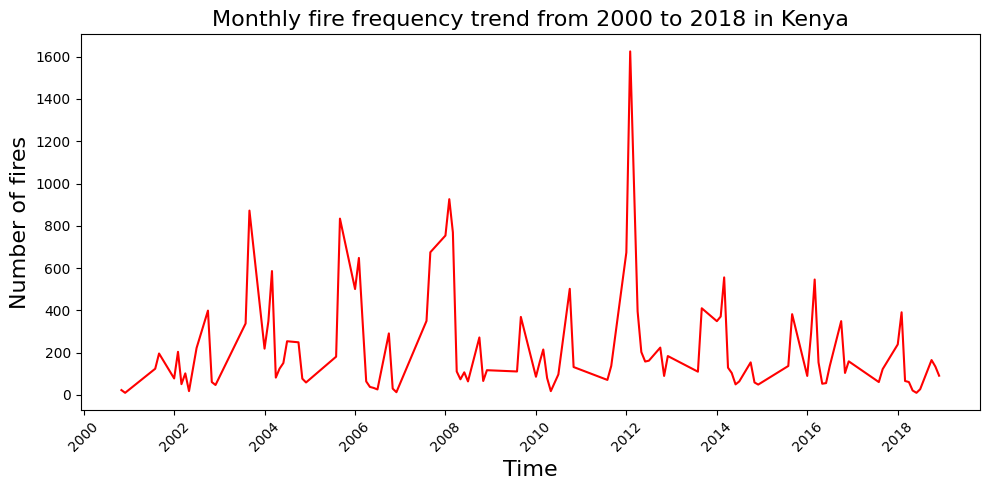

In [9]:
# --- 4. Plot monthly fire frequency -----------------------------------
plt.figure(figsize=(10, 5))
plt.plot(count_ts['Time'], count_ts['count'], color='red')
plt.title('Monthly fire frequency trend from 2000 to 2018 in Kenya', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Number of fires', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


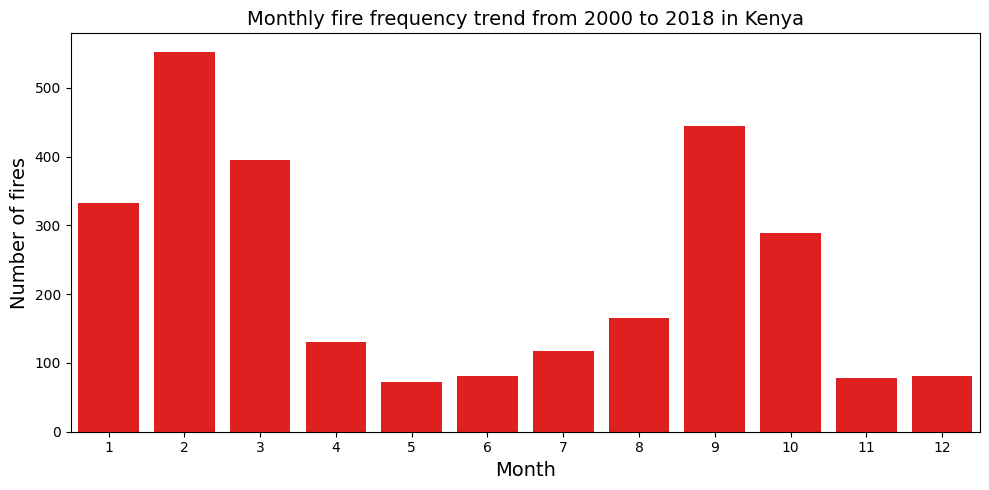

In [10]:
# --- 5. Bar plot of mean count by month -------------------------------
mean_by_month = count_ts.groupby('month')['count'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(data=mean_by_month, x='month', y='count', color='red')
plt.title('Monthly fire frequency trend from 2000 to 2018 in Kenya', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of fires', fontsize=14)
plt.tight_layout()
plt.show()

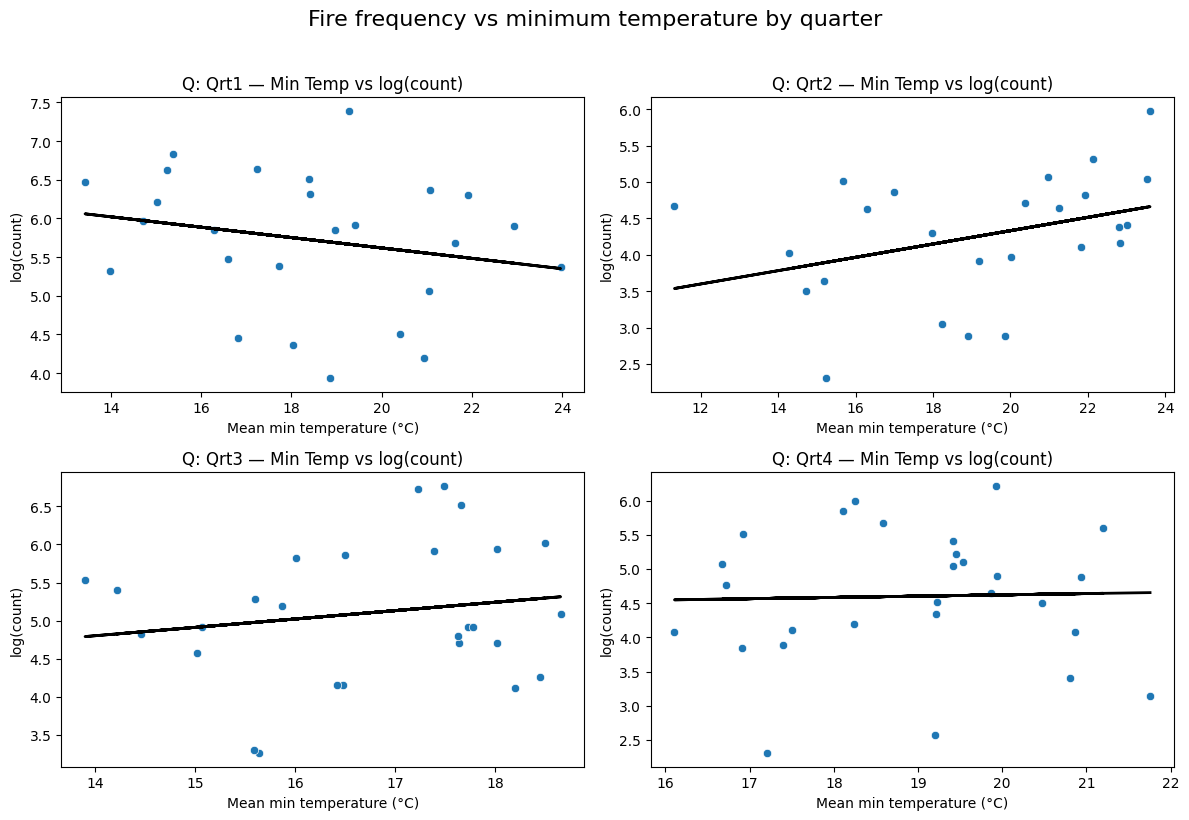

In [11]:
# --- 6. Correlation plots by quarter ----------------------------------
def quarter(m):
    if m < 4:
        return 'Qrt1'
    elif m < 7:
        return 'Qrt2'
    elif m < 10:
        return 'Qrt3'
    else:
        return 'Qrt4'

count_ts['quarter'] = count_ts['month'].apply(quarter)

# Min temp vs log(count)
plt.figure(figsize=(12, 8))
for i, q in enumerate(sorted(count_ts['quarter'].unique())):
    ax = plt.subplot(2, 2, i + 1)
    subset = count_ts[count_ts['quarter'] == q]
    x = subset['mean_min_temp']
    y = np.log(subset['count'])
    sns.scatterplot(x=x, y=y, ax=ax)
    slope, intercept, _, _, _ = stats.linregress(x, y)
    ax.plot(x, intercept + slope * x, lw=2, color='black')
    ax.set_title(f"Q: {q} — Min Temp vs log(count)")
    ax.set_xlabel("Mean min temperature (°C)")
    ax.set_ylabel("log(count)")
plt.suptitle("Fire frequency vs minimum temperature by quarter", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

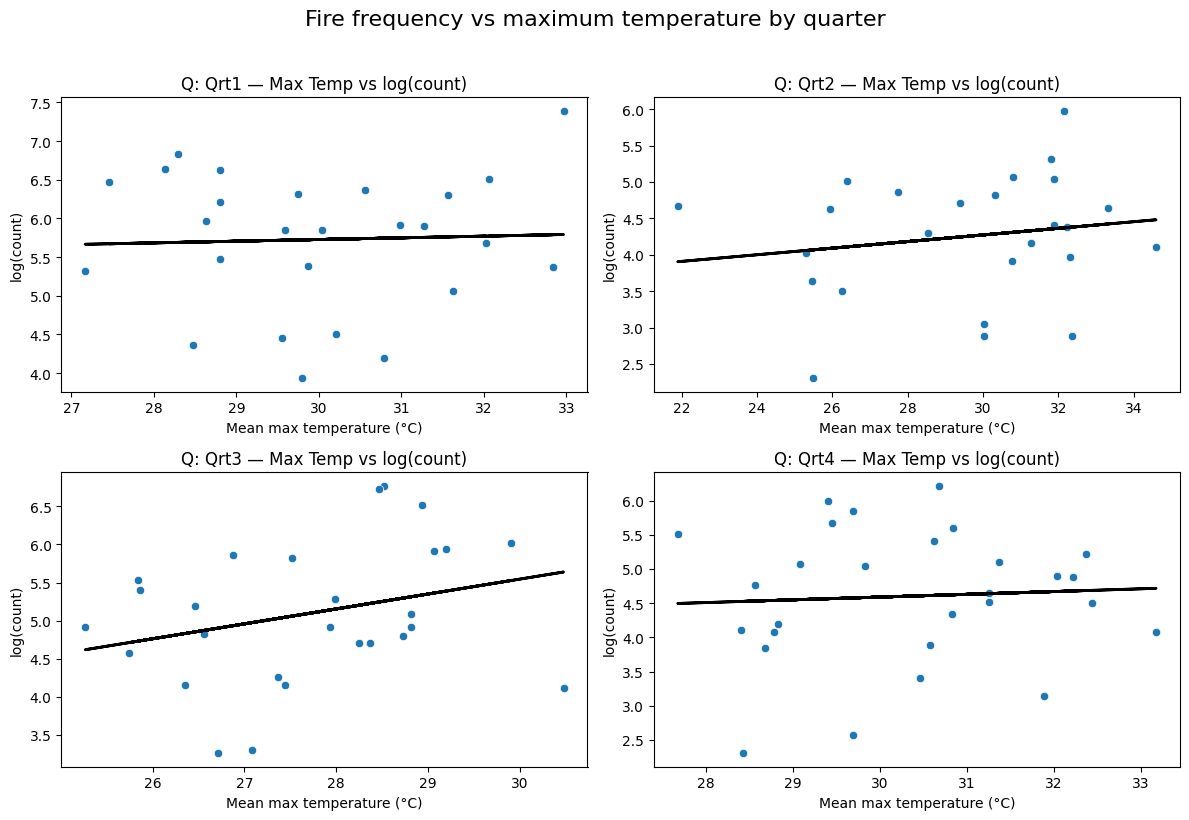

In [12]:
# Max temp vs log(count)
plt.figure(figsize=(12, 8))
for i, q in enumerate(sorted(count_ts['quarter'].unique())):
    ax = plt.subplot(2, 2, i + 1)
    subset = count_ts[count_ts['quarter'] == q]
    x = subset['mean_max_temp']
    y = np.log(subset['count'])
    sns.scatterplot(x=x, y=y, ax=ax)
    slope, intercept, _, _, _ = stats.linregress(x, y)
    ax.plot(x, intercept + slope * x, lw=2, color='black')
    ax.set_title(f"Q: {q} — Max Temp vs log(count)")
    ax.set_xlabel("Mean max temperature (°C)")
    ax.set_ylabel("log(count)")
plt.suptitle("Fire frequency vs maximum temperature by quarter", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


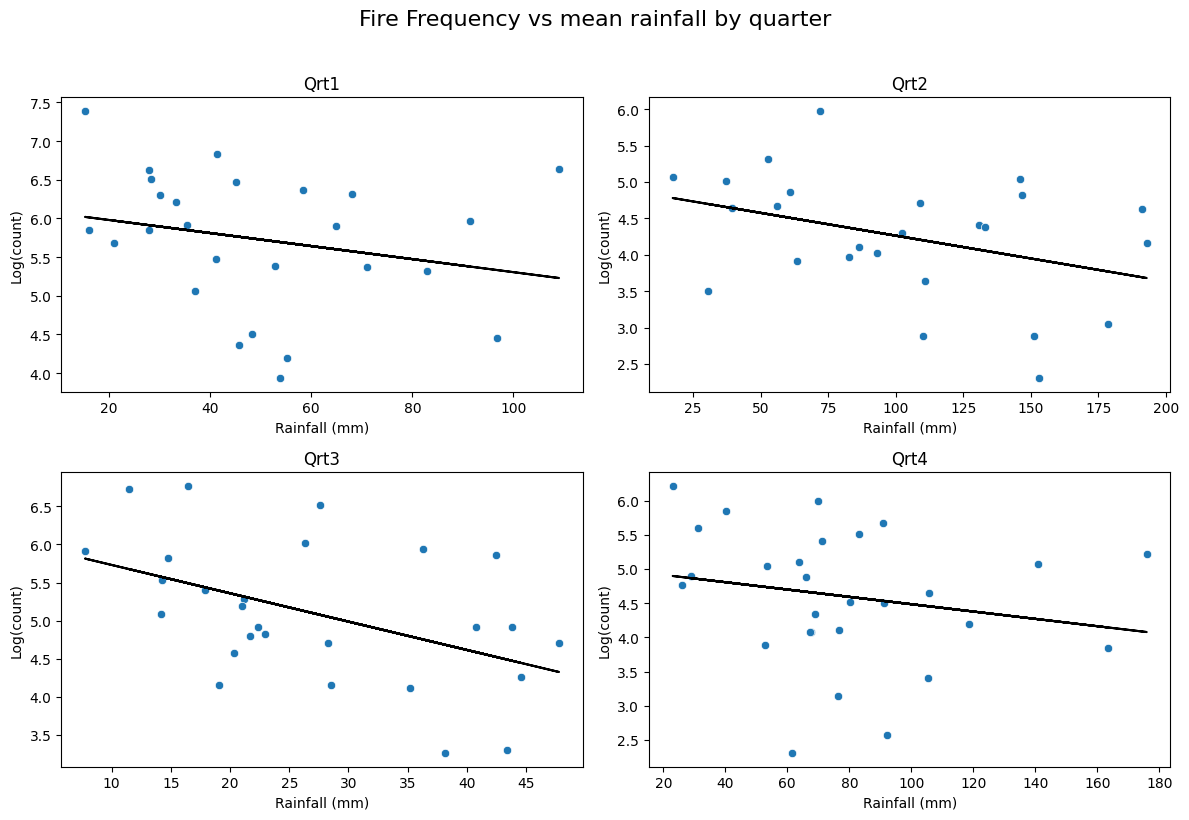

In [13]:
# Rainfall vs log(count)
plt.figure(figsize=(12, 8))
for i, q in enumerate(sorted(count_ts['quarter'].unique())):
    ax = plt.subplot(2, 2, i + 1)
    subset = count_ts[count_ts['quarter'] == q]
    x = subset['mean_rainfall']
    y = np.log(subset['count'])
    sns.scatterplot(x=x, y=y, ax=ax)
    slope, intercept, *_ = stats.linregress(x, y)
    ax.plot(x, intercept + slope * x, color='black')
    ax.set_title(q)
    ax.set_xlabel('Rainfall (mm)')
    ax.set_ylabel('Log(count)')
plt.suptitle("Fire Frequency vs mean rainfall by quarter", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

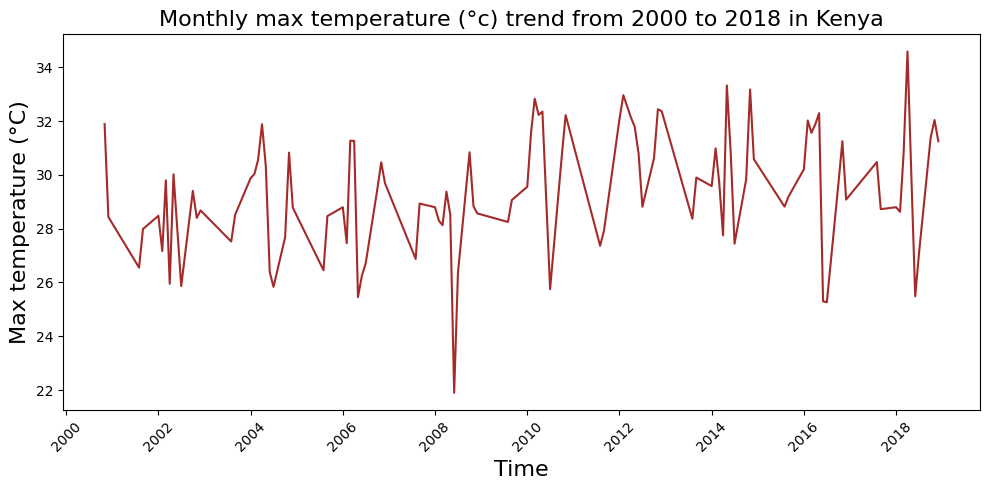

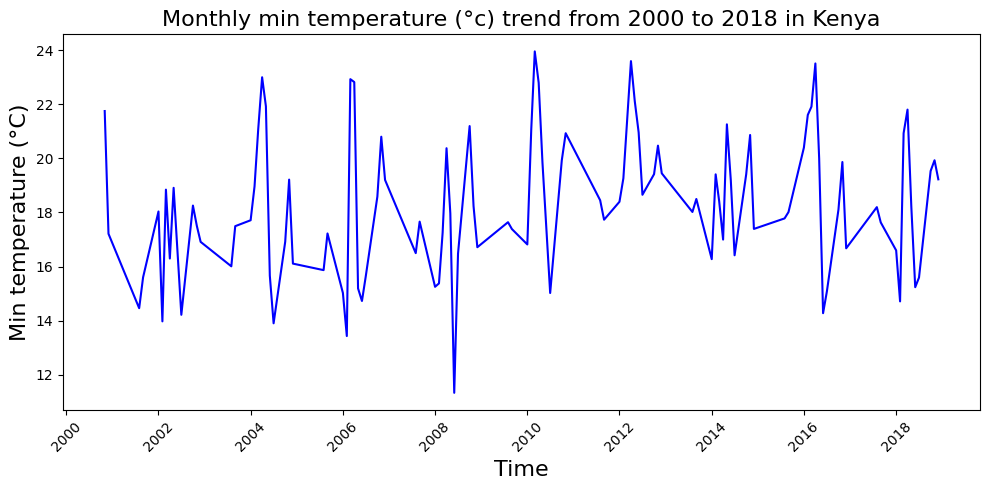

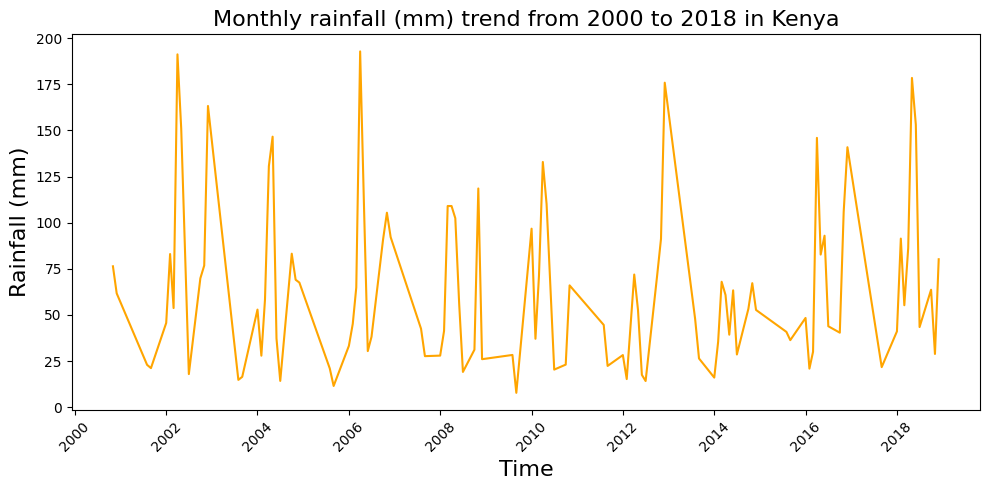

In [14]:
# --- 7. Time series of max, min temperature and rainfall ------------
for var, color, ylabel in [
    ('mean_max_temp', 'brown', 'Max temperature (°C)'),
    ('mean_min_temp', 'blue', 'Min temperature (°C)'),
    ('mean_rainfall', 'orange', 'Rainfall (mm)')
]:
    plt.figure(figsize=(10, 5))
    plt.plot(count_ts['Time'], count_ts[var], color=color)
    plt.title(f'Monthly {ylabel.lower()} trend from 2000 to 2018 in Kenya', fontsize=16)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

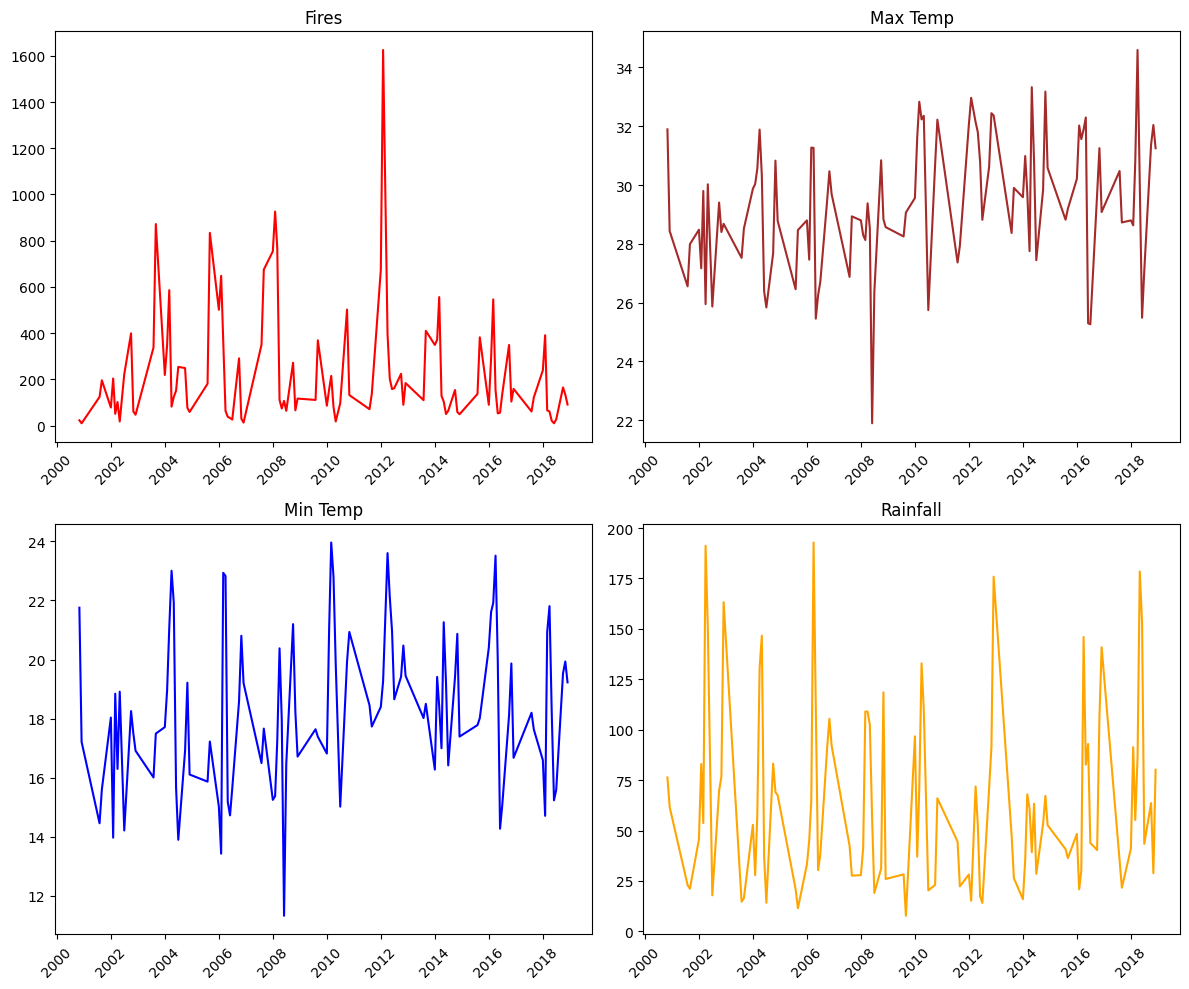

In [15]:
# --- 8. Combined subplots --------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
vars_colors = [
    ('count', 'red', 'Fires'),
    ('mean_max_temp', 'brown', 'Max Temp'),
    ('mean_min_temp', 'blue', 'Min Temp'),
    ('mean_rainfall', 'orange', 'Rainfall')
]
for ax, (var, col, label) in zip(axes.flatten(), vars_colors):
    ax.plot(count_ts['Time'], count_ts[var], color=col)
    ax.set_title(label)
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

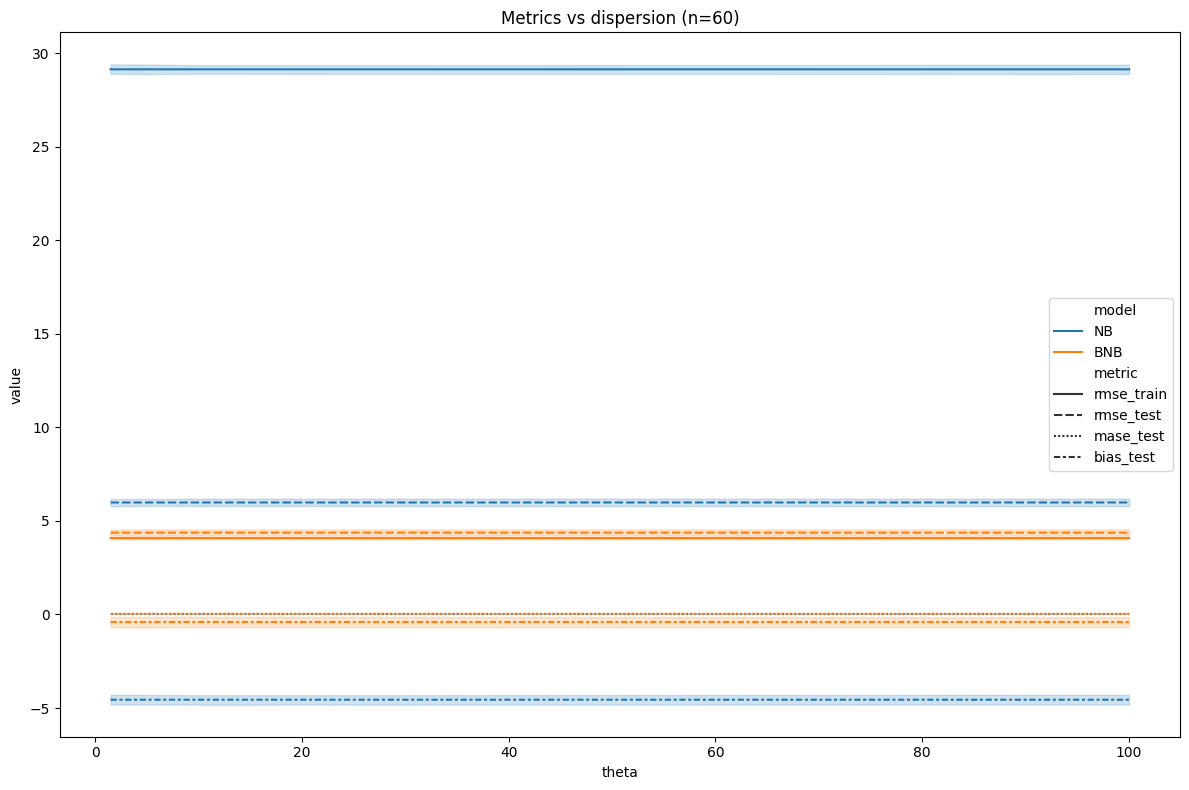

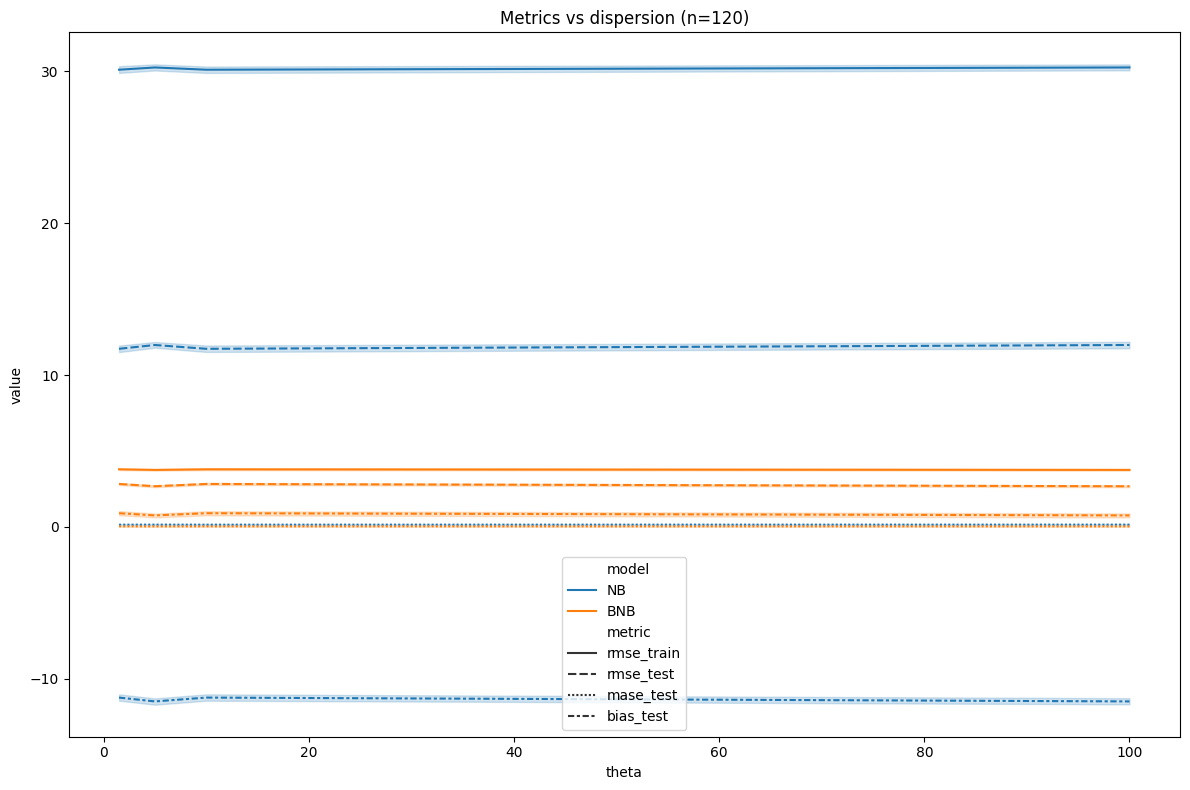

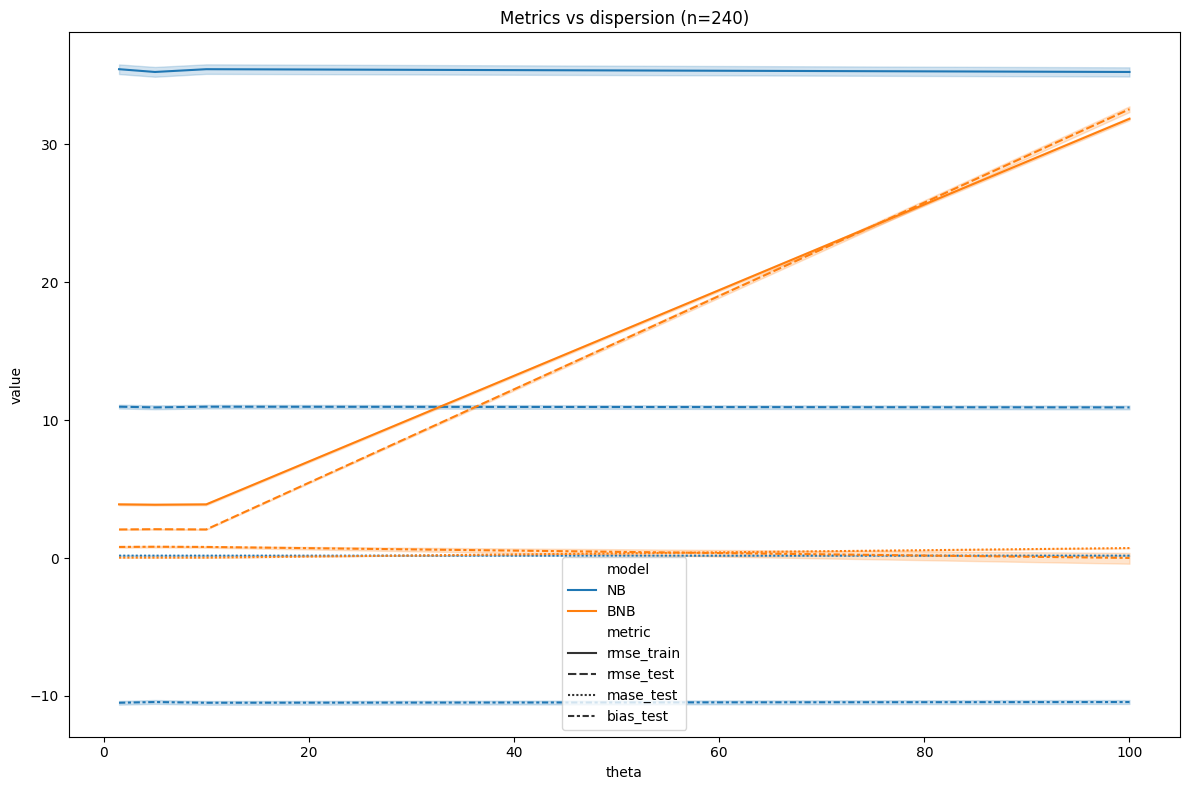

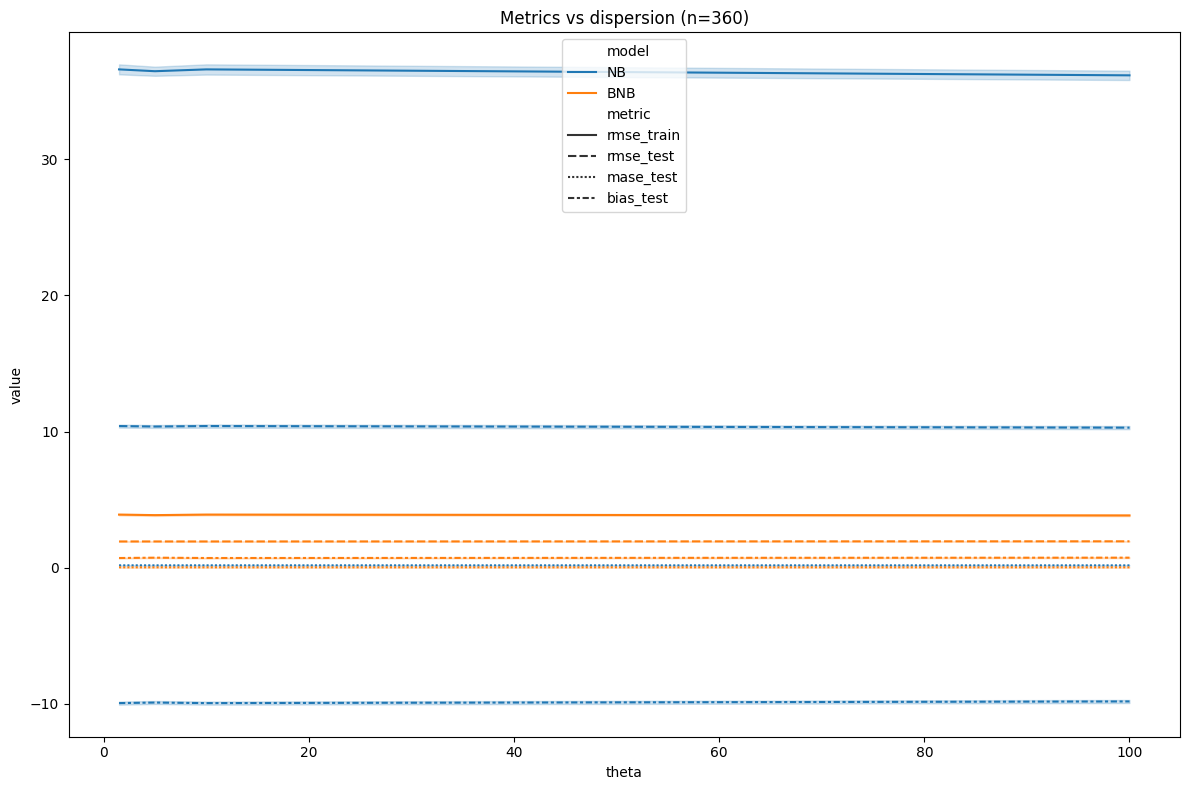

In [16]:
# --- 9. Read and combine model results -------------------------------
# Python lines 103-141 == R lines 95-160
# Note: theta values (1.5, 5, 10, 100) correspond to dispersion parameter θ used
# in the filenames of your R code (e.g., five_year_1.5_metrics.csv represents θ=1.5).


number_map = {
    5: 'five',
    10: 'ten',
    20: 'twenty',
    30: 'thirty'
}





metrics = []
for horizon, theta in [
    (5, 1.5), (10, 1.5), (20, 1.5), (30, 1.5),
    (5, 5), (10, 5), (20, 5), (30, 5),
    (5, 10), (10, 10), (20, 10), (30, 10),
    (5, 100), (10, 100), (20, 100), (30, 100)
]:
    # theta values are derived from your R file suffixes and represent the dispersion parameter
    for suffix in ['', 'b']:
        horizon_word = number_map[horizon]
        fname = f'./Modelling-fire-frequency-in-Kenya/model_results/{horizon_word}_year_{theta}{suffix}_metrics.csv'
        df = pd.read_csv(fname)
        df['model'] = 'BNB' if suffix == 'b' else 'NB'
        df['n'] = 12 * horizon  # n corresponds to sample size in months
        df['theta'] = theta
        metrics.append(df)
all_metrics = pd.concat(metrics, ignore_index=True)
long = all_metrics.melt(
    id_vars=['n', 'theta', 'model'],
    value_vars=['rmse_train', 'rmse_test', 'mase_test', 'bias_test'],
    var_name='metric', value_name='value'
)

# Plotting for each horizon
for horizon in [5, 10, 20, 30]:
    n_value = 12 * horizon
    subset = long[long['n'] == n_value]
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=subset, x='theta', y='value', hue='model', style='metric')
    plt.title(f'Metrics vs dispersion (n={n_value})')
    plt.tight_layout()
    plt.show()

In [17]:
# --- 10. Export combined simulation results --------------------------
final_sim = long.groupby(['metric', 'model', 'n', 'theta'])['value'].mean().reset_index()
final_sim.to_csv('paper_sim_results_py.csv', index=False)

In [18]:
# --- 11. Functions for NB and Bayesian NB ----------------------------
def negbinner2(df, prop=0.8, seed=456):
    np.random.seed(seed)
    n = len(df)
    idx = int(prop * n)
    train, test = df.iloc[:idx], df.iloc[idx:]
    train['season_sin'] = np.sin((2 * train['tyme'] * np.pi / 12)  + np.random.normal(scale=0.1))
    train['season_cos'] = np.cos((2 * train['tyme'] * np.pi / 12)  + np.random.normal(scale=0.1))
    X_train = sm.add_constant(train[['mean_max_temp', 'mean_rainfall', 'season_sin', 'season_cos']])
    y_train = train['count']
    model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial()).fit()
    X_test = sm.add_constant(test[['mean_max_temp', 'mean_rainfall']].assign(
        season_sin=np.sin((2 * test['tyme'] * np.pi) /12 ),
        season_cos=np.cos((2 * test['tyme'] * np.pi) /12 )
    ))
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, np.round(pred_train)))
    rmse_test = np.sqrt(mean_squared_error(test['count'], np.round(pred_test)))
    def mase(actual, pred):
        return np.mean(np.abs(actual - pred)) / np.mean(np.abs(np.diff(train['count'])))
    test_mase = mase(test['count'], np.round(pred_test))
    test_bias = 100 * np.sum(test['count'] - np.round(pred_test)) / np.sum(test['count'])
    return pd.DataFrame([{
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mase_test': test_mase,
        'bias_test': test_bias,
        'n': n,
        'prop': prop
    }])

In [19]:
import pymc as pm
import pytensor.tensor as tt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import arviz as az

def stanbinner3(df, prop=0.8, seed=456):
    np.random.seed(seed)
    data = df.copy()
    n = len(data['count'])
    data['tyme'] = np.arange(1, n+1)
    noise_sin = np.random.normal(loc=0, scale=0.1)
    noise_cos = np.random.normal(loc=0, scale=0.1)
    data['sin_term'] = np.sin((2 * data['tyme'] * np.pi / 12) + noise_sin)
    data['cos_term'] = np.cos((2 * data['tyme'] * np.pi /12) + noise_cos)
    train_idx = int(round(prop * n))
    train = data.iloc[:train_idx].reset_index(drop=True)
    test  = data.iloc[train_idx:].reset_index(drop=True)

    # PyMC4 NB model
    with pm.Model() as pymc_nb:
        # Define observed data as PyTensor shared variables
        obs_id = pm.MutableData("obs_id", np.arange(len(train)), dims="data_dim") # Add obs_id for dynamic sizing
        mean_max_temp_shared = pm.Data("mean_max_temp", train["mean_max_temp"].values, dims="data_dim")
        mean_rainfall_shared = pm.Data("mean_rainfall", train["mean_rainfall"].values, dims="data_dim")
        sin_term_shared = pm.Data("sin_term", train["sin_term"].values, dims="data_dim")
        cos_term_shared = pm.Data("cos_term", train["cos_term"].values, dims="data_dim")


        intercept = pm.Normal("Intercept", mu=0, sigma=5)
        beta_max     = pm.Normal("beta_mean_max_temp", mu=0, sigma=2.5)
        beta_rain    = pm.Normal("beta_mean_rainfall", mu=0, sigma=2.5)
        beta_sin     = pm.Normal("beta_sin_term", mu=0, sigma=2.5)
        beta_cos     = pm.Normal("beta_cos_term", mu=0, sigma=2.5)
        α         = pm.Exponential("alpha", lam=1)

        μ = tt.exp(
            intercept +
            beta_max  * mean_max_temp_shared +
            beta_rain * mean_rainfall_shared +
            beta_sin  * sin_term_shared +
            beta_cos  * cos_term_shared
        )

        y_obs = pm.NegativeBinomial("y_obs",
                                    mu=μ,
                                    alpha=α,
                                    observed=train["count"].values,
                                    dims="data_dim") # Use dims for dynamic sizing

        trace = pm.sample(draws=2000, tune=1000, chains=4,
                          random_seed=seed, return_inferencedata=True)

    # Posterior predictive & point estimates
    with pymc_nb:
        # Set the data to train data for train predictions
        pm.set_data(
            {
                "mean_max_temp": train["mean_max_temp"].values,
                "mean_rainfall": train["mean_rainfall"].values,
                "sin_term": train["sin_term"].values,
                "cos_term": train["cos_term"].values,
                 "obs_id": np.arange(len(train)) # Update obs_id with train data size
            }
        )
        ppc_train = pm.sample_posterior_predictive(trace, var_names=["y_obs"], predictions=True)

        # Set the data to test data for test predictions
        pm.set_data(
            {
                "mean_max_temp": test["mean_max_temp"].values,
                "mean_rainfall": test["mean_rainfall"].values,
                "sin_term": test["sin_term"].values,
                "cos_term": test["cos_term"].values,
                 "obs_id": np.arange(len(test)) # Update obs_id with test data size
            }
        )
        ppc_test  = pm.sample_posterior_predictive(trace, var_names=["y_obs"], predictions=True)

    pred_train2 = np.round(ppc_train.predictions["y_obs"].mean(dim=["chain","draw"]).values)
    pred_test2  = np.round(ppc_test.predictions["y_obs"].mean(dim=["chain","draw"]).values)

    rmse_train = np.sqrt(mean_squared_error(train['count'], pred_train2))
    rmse_test  = np.sqrt(mean_squared_error(test['count'], pred_test2))
    errors_test = np.abs(test['count'] - pred_test2)
    naive_errors = np.abs(np.diff(test['count']))
    mase_test = errors_test.mean() / naive_errors.mean()
    bias_test = 100 * (pred_test2 - test['count']).sum() / test['count'].sum()

    return pd.DataFrame([{  'rmse_train': rmse_train,
                             'rmse_test':  rmse_test,
                             'mase_test':  mase_test,
                             'bias_test':  bias_test,
                             'n':          n,
                             'prop':       prop }])

In [23]:
series_data = pd.read_csv('fire_data_2000-18.csv')    # read_csv("fire_data_2000-18.csv")

# add quarter and tyme (equivalent to the R mutate calls)
def quarter(m):
    if m < 4:
        return 1
    elif m < 7:
        return 2
    elif m < 10:
        return 3
    else:
        return 4

series_data2 = series_data.copy()
series_data2['qrt']  = series_data2['month'].apply(quarter)          # mutate(qrt = ...)
series_data2['tyme'] = np.arange(1, len(series_data2) + 1)

In [24]:
# ---- Set seed ----
np.random.seed(76568)                                                # set.seed(76568)

# ---- Standard NB (assumes you have a negbinner2() Python function) ----
nb_result80 = negbinner2(series_data2, prop=0.8)                     # negbinner2(..., prop = 0.8)
nb_result90 = negbinner2(series_data2, prop=0.9)                     # negbinner2(..., prop = 0.9)
nb_result95 = negbinner2(series_data2, prop=0.95)                    # negbinner2(..., prop = 0.95)

# ---- Bayesian NBT (your Bambi‐based stanbinner3 from before) ----
bnbt_result80 = stanbinner3(series_data2, prop=0.8)                 # stanbinner3(..., prop = 0.8)
bnbt_result90 = stanbinner3(series_data2, prop=0.9)                 # stanbinner3(..., prop = 0.9)
bnbt_result95 = stanbinner3(series_data2, prop=0.95)

C:\Users\Mohamed Elsafty\AppData\Local\Temp\ipykernel_24172\2718870266.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['season_sin'] = np.sin((2 * train['tyme'] * np.pi / 12)  + np.random.normal(scale=0.1))
C:\Users\Mohamed Elsafty\AppData\Local\Temp\ipykernel_24172\2718870266.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['season_cos'] = np.cos((2 * train['tyme'] * np.pi / 12)  + np.random.normal(scale=0.1))
c:\ProgramData\anaconda3\envs\fire\Lib\site-packages\statsmodels\genmod\famili

Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 756 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y_obs]


Output()

c:\ProgramData\anaconda3\envs\fire\Lib\site-packages\pymc\model\core.py:2137: ShapeWarning: You are resizing a variable with dimension 'data_dim' which was initialized as a mutable dimension by another variable ('obs_id'). Remember to update that variable with the correct shape to avoid shape issues.
  model.set_data(variable_name, new_value, coords=coords)
Sampling: [y_obs]


Output()

c:\ProgramData\anaconda3\envs\fire\Lib\site-packages\pymc\data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
c:\ProgramData\anaconda3\envs\fire\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1003: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, beta_mean_max_temp, beta_mean_rainfall, beta_sin_term, beta_cos_term, alpha]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1176 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y_obs]


Output()

c:\ProgramData\anaconda3\envs\fire\Lib\site-packages\pymc\model\core.py:2137: ShapeWarning: You are resizing a variable with dimension 'data_dim' which was initialized as a mutable dimension by another variable ('obs_id'). Remember to update that variable with the correct shape to avoid shape issues.
  model.set_data(variable_name, new_value, coords=coords)
Sampling: [y_obs]


Output()

c:\ProgramData\anaconda3\envs\fire\Lib\site-packages\pymc\data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
c:\ProgramData\anaconda3\envs\fire\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1003: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, beta_mean_max_temp, beta_mean_rainfall, beta_sin_term, beta_cos_term, alpha]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 968 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y_obs]


Output()

c:\ProgramData\anaconda3\envs\fire\Lib\site-packages\pymc\model\core.py:2137: ShapeWarning: You are resizing a variable with dimension 'data_dim' which was initialized as a mutable dimension by another variable ('obs_id'). Remember to update that variable with the correct shape to avoid shape issues.
  model.set_data(variable_name, new_value, coords=coords)
Sampling: [y_obs]


Output()

In [25]:
# ---- Combine and round results just like the R rbind + mutate_if(…, round, 2) ----
combined_results = pd.concat([
    nb_result80.assign(method="NB80"),
    bnbt_result80.assign(method="BNBT80")
], ignore_index=True)

In [26]:
# round all numeric columns to 2 decimals
for col in combined_results.select_dtypes(include="number").columns:
    combined_results[col] = combined_results[col].round(2)

print(combined_results)

   rmse_train  rmse_test  mase_test  bias_test    n  prop  method
0      221.81     148.38       0.64     -50.57  106   0.8    NB80
1      221.71     154.02       1.05      52.38  106   0.8  BNBT80


In [27]:
# ---- Fit the model on the whole dataset to get beta estimates ----
x = series_data2.copy()
np.random.seed(456)                                                 # set.seed(456)

# re-create tyme & noise terms as in stanbinner3
n = len(x)
x['tyme'] = np.arange(1, n+1)
noise_sin = np.random.normal(0, 0.1)
noise_cos = np.random.normal(0, 0.1)
x['sin_term'] = np.sin((2 * x['tyme'] * np.pi / 12) + noise_sin) # seasonality change 7
x['cos_term'] = np.cos((2 * x['tyme'] * np.pi / 12) + noise_cos) # seasonality change 8


In [28]:
# ---- Fit the model on the whole dataset to get beta estimates ----
# This code is based on the PyMC model in the stanbinner3 function
with pm.Model() as full_model:
    # Define observed data as PyTensor shared variables
    obs_id = pm.MutableData("obs_id", np.arange(len(x)), dims="data_dim") # Add obs_id for dynamic sizing
    mean_max_temp_shared = pm.Data("mean_max_temp", x["mean_max_temp"].values, dims="data_dim")
    mean_rainfall_shared = pm.Data("mean_rainfall", x["mean_rainfall"].values, dims="data_dim")
    sin_term_shared = pm.Data("sin_term", x["sin_term"].values, dims="data_dim")
    cos_term_shared = pm.Data("cos_term", x["cos_term"].values, dims="data_dim")

    intercept = pm.Normal("Intercept", mu=0, sigma=5)
    beta_max     = pm.Normal("beta_mean_max_temp", mu=0, sigma=2.5)
    beta_rain    = pm.Normal("beta_mean_rainfall", mu=0, sigma=2.5)
    beta_sin     = pm.Normal("beta_sin_term", mu=0, sigma=2.5)
    beta_cos     = pm.Normal("beta_cos_term", mu=0, sigma=2.5)
    α         = pm.Exponential("alpha", lam=1)

    μ = tt.exp(
        intercept +
        beta_max  * mean_max_temp_shared +
        beta_rain * mean_rainfall_shared +
        beta_sin  * sin_term_shared +
        beta_cos  * cos_term_shared
    )

    y_obs = pm.NegativeBinomial("y_obs",
                                mu=μ,
                                alpha=α,
                                observed=x["count"].values,
                                dims="data_dim") # Use dims for dynamic sizing

    full_fit = pm.sample(draws=2000, tune=1000, chains=4,
                      random_seed=456, return_inferencedata=True)

c:\ProgramData\anaconda3\envs\fire\Lib\site-packages\pymc\data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
c:\ProgramData\anaconda3\envs\fire\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1003: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, beta_mean_max_temp, beta_mean_rainfall, beta_sin_term, beta_cos_term, alpha]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 944 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [29]:
# ---- Extract and tidy the output (broom.mixed::tidy + posterior_interval) ----
# get posterior summaries (mean, sd, etc.)
tidied = az.summary(full_fit, var_names=["Intercept",
                                          "beta_mean_max_temp",
                                          "beta_mean_rainfall",
                                          "beta_sin_term",
                                          "beta_cos_term",
                                          "alpha"],
                    kind="stats")

In [30]:
 # get 95% credible intervals
ci_dataset = az.hdi(full_fit,
            hdi_prob=0.95)[["Intercept",
                            "beta_mean_max_temp",
                            "beta_mean_rainfall",
                            "beta_sin_term",
                            "beta_cos_term",
                            "alpha"]]

# Convert the ci Dataset to a DataFrame
ci_df = ci_dataset.to_dataframe()

# combine summaries & intervals (like cbind in R)
# tidied is already a DataFrame with index as variable names
# ci_df is now a DataFrame with index as variable names and hdi bounds as columns
comb_table = pd.concat([tidied, ci_df], axis=1)

print(comb_table)

                     mean     sd  hdi_3%  hdi_97%  Intercept  \
Intercept           4.307  1.144   2.183    6.486        NaN   
beta_mean_max_temp  0.050  0.039  -0.027    0.121        NaN   
beta_mean_rainfall -0.008  0.002  -0.011   -0.004        NaN   
beta_sin_term       0.395  0.127   0.156    0.635        NaN   
beta_cos_term      -0.116  0.123  -0.346    0.117        NaN   
alpha               1.449  0.183   1.089    1.779        NaN   
lower                 NaN    NaN     NaN      NaN   2.126145   
higher                NaN    NaN     NaN      NaN   6.600220   

                    beta_mean_max_temp  beta_mean_rainfall  beta_sin_term  \
Intercept                          NaN                 NaN            NaN   
beta_mean_max_temp                 NaN                 NaN            NaN   
beta_mean_rainfall                 NaN                 NaN            NaN   
beta_sin_term                      NaN                 NaN            NaN   
beta_cos_term                      NaN

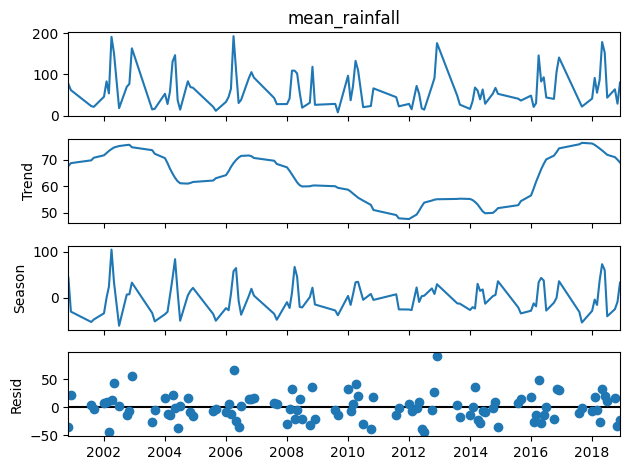

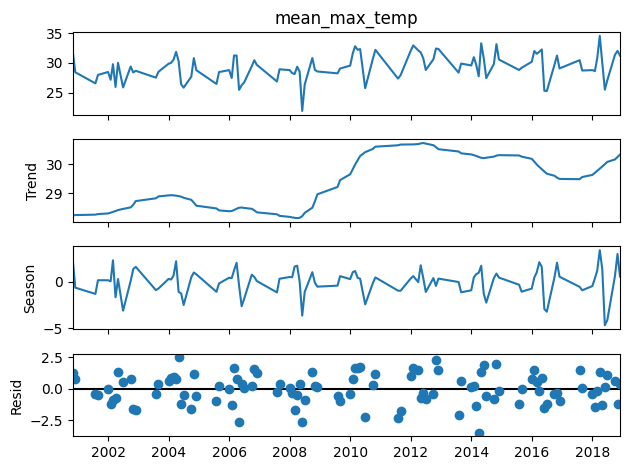

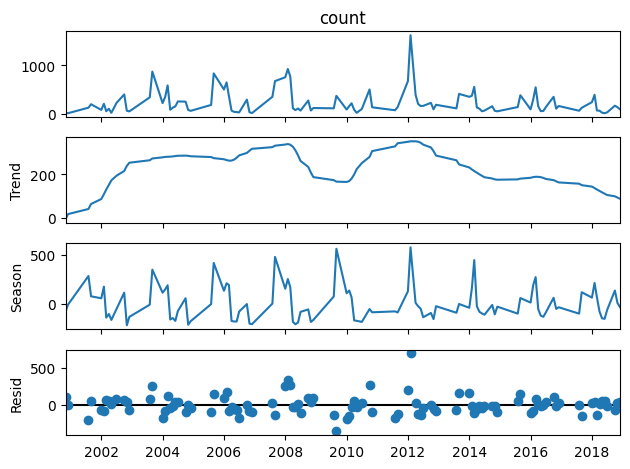

In [31]:
# --- 12. Time series decomposition -----------------------------------
# Python lines 186-202 == R lines 262-290
rain_ts = fire_clim.set_index('Time')['mean_rainfall']
stl_rain = STL(rain_ts, period=12).fit()
stl_rain.plot(); plt.show()

temp_ts = fire_clim.set_index('Time')['mean_max_temp']
stl_temp = STL(temp_ts, period=12).fit()
stl_temp.plot(); plt.show()

fire_ts = fire_clim.set_index('Time')['count']
stl_fire = STL(fire_ts, period=12).fit()
stl_fire.plot(); plt.show()

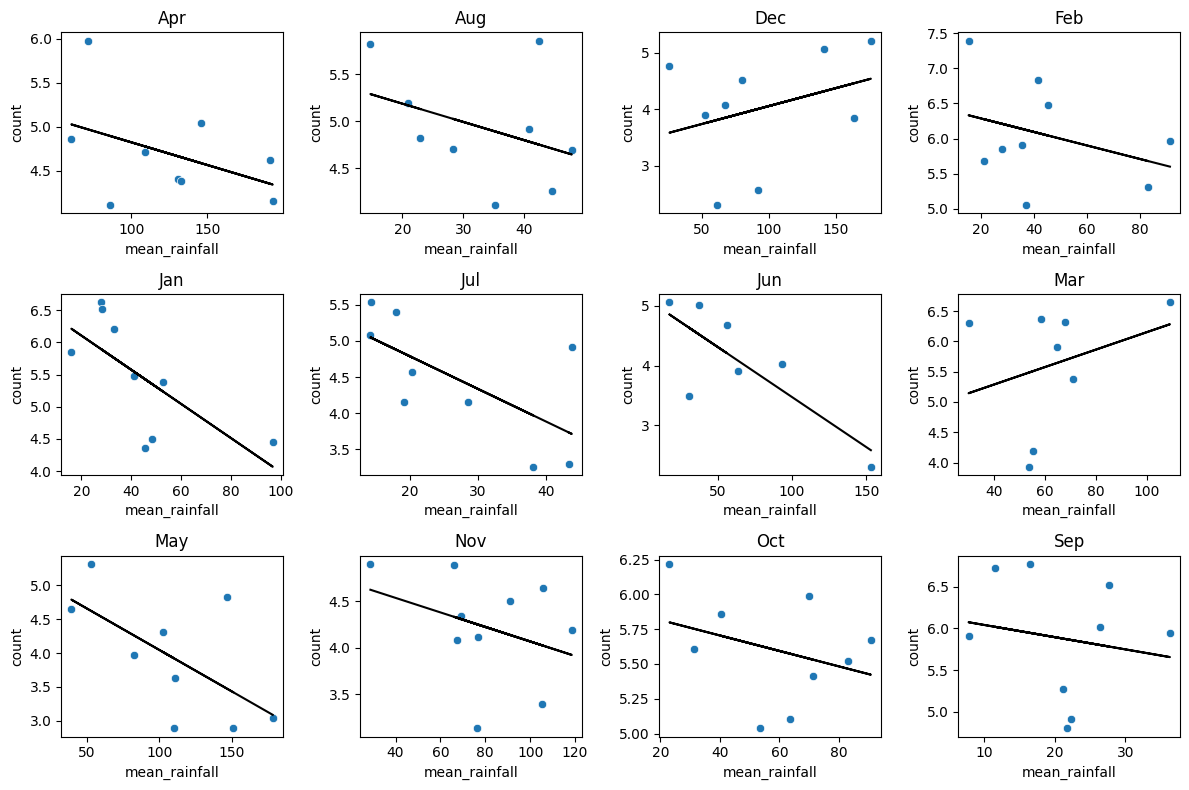

In [32]:
# que: need to implement for max temp as well 1378 to 1405 R code
# ans: will do it below
fire_clim['month2'] = fire_clim['month'].map(dict(enumerate(
    ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], start=1)))
plt.figure(figsize=(12, 8))
for i, m in enumerate(sorted(fire_clim['month2'].unique())):
    ax = plt.subplot(3, 4, i + 1)
    sub = fire_clim[fire_clim['month2'] == m]
    sns.scatterplot(x='mean_rainfall', y=np.log(sub['count']), data=sub, ax=ax)
    slope, intercept, *_ = stats.linregress(sub['mean_rainfall'], np.log(sub['count']))
    # que: there was x before why not intercept+slope*x now?
    # ans: does not make a difference, both are correct, just differenct ways of doing the same thing
    ax.plot(sub['mean_rainfall'], intercept + slope * sub['mean_rainfall'], color='black')
    ax.set_title(m)
plt.tight_layout()
plt.show()

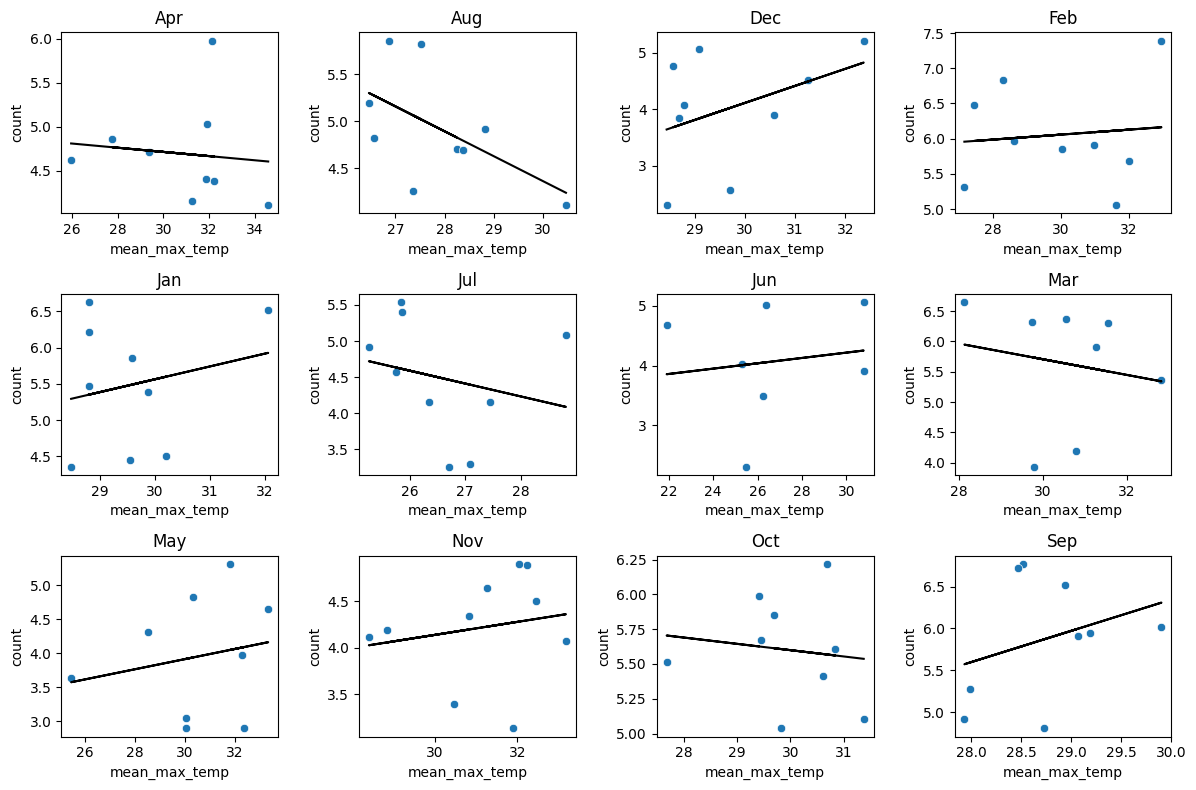

In [33]:
#after the rainfall, I added the max temp plot like noted
# IMPORTANT: I changed the mapping of the x-axis (line 1383) in R code to the correct column

 # Fire frequency vs maximum temperature by month (equivalent to R’s corplot2)
plt.figure(figsize=(12, 8))
for i, m in enumerate(sorted(fire_clim['month2'].unique())):
    ax = plt.subplot(3, 4, i + 1)
    sub = fire_clim[fire_clim['month2'] == m]

    # scatter points (R’s geom_point)
    sns.scatterplot(x='mean_max_temp',
                    y=np.log(sub['count']),
                    data=sub,
                    ax=ax)

    # regression line (R’s geom_smooth(method='lm'))
    slope, intercept, *_ = stats.linregress(
        sub['mean_max_temp'],
        np.log(sub['count'])
    )
    ax.plot(sub['mean_max_temp'],
            intercept + slope * sub['mean_max_temp'],
            color='black')

    ax.set_title(m)

plt.tight_layout()
plt.show()
# here marks the end of the addition of the max temp plot

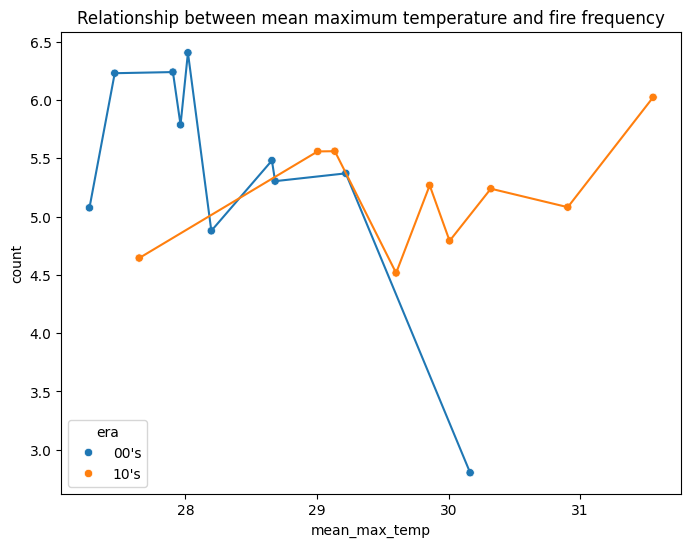

In [34]:
# --- 14. Era comparison ----------------------------------------------

# que: this needs to be done for rainfall as well lines 1434 to 1461 R code
# ans: will do it below
fire_clim['era'] = np.where(fire_clim['year'] < 2010, "00's", "10's")
avg = fire_clim.groupby(['year', 'era']).agg({'mean_max_temp': 'mean', 'count': 'mean'}).reset_index()
plt.figure(figsize=(8, 6))
sns.scatterplot(x='mean_max_temp', y=np.log(avg['count']), hue='era', data=avg)
sns.lineplot(x='mean_max_temp', y=np.log(avg['count']), hue='era', data=avg, legend=False)
plt.title('Relationship between mean maximum temperature and fire frequency')
plt.show()

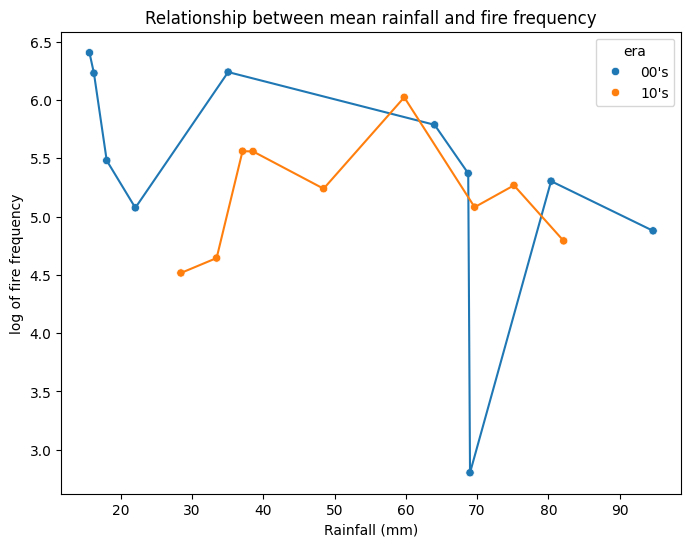

In [35]:
# I will add the mean raifall like stated above
# Relationship between mean rainfall and fire frequency (equivalent to R’s rain_fire_avg)
avg_rain = (
    fire_clim
    .groupby(['year', 'era'])
    .agg({'mean_rainfall': 'mean', 'count': 'mean'})
    .reset_index()
)

plt.figure(figsize=(8, 6))

# scatter points (geom_point)
sns.scatterplot(
    x='mean_rainfall',
    y=np.log(avg_rain['count']),
    hue='era',
    data=avg_rain
)

# regression line (geom_smooth(method='lm'))
sns.lineplot(
    x='mean_rainfall',
    y=np.log(avg_rain['count']),
    hue='era',
    data=avg_rain,
    legend=False
)

plt.title('Relationship between mean rainfall and fire frequency')
plt.xlabel('Rainfall (mm)')
plt.ylabel('log of fire frequency')

plt.show()

In [36]:
#  combine Bayesian results
# rbind(bnb_result80, bnb_result90, bnb_result95) %>% data.frame()
bnb_results = pd.concat([bnbt_result80, bnbt_result90, bnbt_result95], ignore_index=True)
print(bnb_results)

#  fit NB and Bayesian models on the same train/test split
n = len(series_data2['count'])                        # R: n = length(series_data2$count)
# The variable `prop` is not defined in this cell, it should be passed as an argument or defined before use.
# Assuming prop is intended to be 0.8 based on the previous cell's usage.
prop = 0.8
idx = round(prop * n)                                 # R: trainIndex <- round(prop*n)
fireTrain = series_data2.iloc[:idx]                   # R: fireTrain <- series_data2[1:trainIndex,]
fireTest  = series_data2.iloc[idx:]                   # R: fireTest  <- series_data2[(trainIndex+1):n,]

   rmse_train   rmse_test  mase_test  bias_test    n  prop
0  221.705448  154.017006   1.051179  52.378011  106  0.80
1  214.538771  166.108672   1.519288  84.928410  106  0.90
2  214.612799  103.356664   1.477729  99.063232  106  0.95


In [37]:
train = fireTrain.copy()
train['sin'] = np.sin(((2*train['tyme']*np.pi)/12) + np.random.normal(scale=0.1)) # seasonality change 9
train['cos'] = np.cos(((2*train['tyme']*np.pi)/12) + np.random.normal(scale=0.1)) # seasonality change 10
X_nb = sm.add_constant(train[['mean_max_temp','mean_rainfall','sin','cos']])
y_nb = train['count']
glmNB = sm.GLM(y_nb, X_nb, family=sm.families.NegativeBinomial()).fit()

c:\ProgramData\anaconda3\envs\fire\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [38]:
# R lines 444–451: NB prediction intervals via ciTools::add_pi
# Python: approximate using model.get_prediction().conf_int()
pred_nb = glmNB.get_prediction(sm.add_constant(
    fireTest[['mean_max_temp','mean_rainfall']].assign(
        sin=np.sin((2*fireTest['tyme']*np.pi)/12), # seasonality change 11
        cos=np.cos((2*fireTest['tyme']*np.pi)/12)  # seasonality change 12
    )
))
intervals_nb = pred_nb.conf_int(alpha=0.05)
nb_int_df = pd.DataFrame(intervals_nb, columns=['lower','upper'])
nb_int_df['count'] = fireTest['count'].values
nb_int_df['pred']  = np.round(pred_nb.predicted_mean).astype(int)
nb_int_df.to_csv('prediction_intervals2.csv', index=False)
print(nb_int_df)


         lower       upper  count  pred
0   250.472604  671.322469    292   410
1   290.491292  694.004422    546   449
2   110.685256  416.249694    154   215
3   200.838311  501.950585     53   318
4    94.311292  338.828578     56   179
5   110.659310  349.863139    137   197
6   123.322202  302.957616    349   193
7    70.798585  170.918989    104   110
8    44.006517  122.175481    159    73
9   110.549742  280.584988     61   176
10  142.618658  323.263628    122   215
11  167.043190  346.760650    239   241
12  132.160698  347.192257    391   214
13  244.952627  538.527483     66   363
14  197.384998  690.620028     61   369
15   67.472542  317.012256     21   146
16   52.042946  268.692096     10   118
17  134.907896  340.877974     27   214
18  112.058554  280.499381    165   177
19  105.617866  362.615939    134   196
20   79.122836  194.188753     91   124


In [41]:
# R lines 453–464: BNB prediction intervals
# Python: placeholder for posterior predictive intervals
# intervals_bnb = your_bayesian_model.predictive_interval(fireTest, prob=0.95)
# prd2 = posterior_samples.mean(axis=0)
# build preds_bnb similarly, then:
# preds_bnb_df.to_csv('prediction_intervals_pap.csv')
# here instead of ('prediction_intervals_pap.csv') it will be saved to ('prediction_intervals2') check the code above
# R lines 466–472: review
pred_intBNB = pd.read_csv('prediction_intervals2.csv')
print(pred_intBNB.head())

# R lines 474–494: combine NB & BNB data
nbdata  = nb_int_df[['count','lower','upper','pred']].copy()
nbdata['model'] = 'NB'

bnbdata = pred_intBNB[['count','lower','upper','pred']].copy()
bnbdata['model'] = 'BNB'

pidata = pd.concat([nbdata, bnbdata], ignore_index=True)

        lower       upper  count  pred
0  250.472604  671.322469    292   410
1  290.491292  694.004422    546   449
2  110.685256  416.249694    154   215
3  200.838311  501.950585     53   318
4   94.311292  338.828578     56   179


In [50]:
# Maintain same functionality as R code: timer = series_data2[175:218,]
# Purpose: Extract time information for test set to create proper time axis for plots

# IMPORTANT: Use EXACTLY the same split as fireTest was created (Cell 31)
# Cell 31 used: idx = round(prop * n), fireTest = series_data2.iloc[idx:]
n = len(series_data2)
prop = 0.8  
train_size = round(prop * n)  # MUST match Cell 31: round(0.8 * 106) = 85
test_start_idx = train_size  # fireTest starts at idx (Python 0-indexed)
test_end_idx = n

print(f"Dataset size: {n} rows")
print(f"Matching Cell 31: trainIndex = round(0.8 * {n}) = {train_size}")
print(f"Test set (fireTest): rows {test_start_idx}:{test_end_idx-1} ({test_end_idx-test_start_idx} rows)")

# Extract timer - must match fireTest exactly
# Cell 31: fireTest = series_data2.iloc[idx:]  where idx = round(prop * n) = 85
timer = series_data2.iloc[test_start_idx:test_end_idx].copy()

# Create month-year labels (same as R code)
timer['month_name'] = timer['month'].apply(lambda x: ['Jan','Feb','Mar','Apr','May','Jun',
                                                      'Jul','Aug','Sep','Oct','Nov','Dec'][x-1])
timer['month_year'] = timer['month_name'] + '-' + timer['year'].astype(str)
timer['month_year2'] = pd.to_datetime(timer[['year','month']].assign(day=1))

print(f"Timer shape: {timer.shape}")
print(f"Time range: {timer['month_year'].iloc[0]} to {timer['month_year'].iloc[-1]}")

# Verify this matches fireTest size
print(f"Timer rows: {len(timer)}, should match fireTest rows: {len(fireTest)}")

# Add time component to pidata (same as R: rep(timer$month_year2, 2))
expected_pidata_rows = 2 * len(timer)
print(f"pidata should have {expected_pidata_rows} rows")
print(f"pidata actual shape: {pidata.shape}")

if len(pidata) == expected_pidata_rows:
    # R code: pidata$month_year <- rep(timer$month_year2, 2)
    pidata['month_year'] = np.tile(timer['month_year2'].values, 2)
    print("✅ Time column added successfully!")
    print(f"pidata now has columns: {list(pidata.columns)}")
else:
    print(f"❌ Error: pidata has {len(pidata)} rows, expected {expected_pidata_rows}")
    print("Sizes don't match - will still add time but with warning")
    # Add time anyway but truncate if necessary
    time_values = np.tile(timer['month_year2'].values, 2)
    if len(time_values) > len(pidata):
        time_values = time_values[:len(pidata)]
    pidata['month_year'] = time_values[:len(pidata)]
    print(f"Added time column with {len(pidata)} values")

Dataset size: 106 rows
Matching Cell 31: trainIndex = round(0.8 * 106) = 85
Test set (fireTest): rows 85:105 (21 rows)
Timer shape: (21, 16)
Time range: Feb-2016 to Dec-2018
Timer rows: 21, should match fireTest rows: 21
pidata should have 42 rows
pidata actual shape: (42, 5)
✅ Time column added successfully!
pidata now has columns: ['count', 'lower', 'upper', 'pred', 'model', 'month_year']


In [51]:
# R lines 496–510: build df for ribbon plots
# Fix: Use actual test set size instead of hardcoded 44
test_set_size = len(nbdata)
df = pd.DataFrame({
    'x': np.arange(1, test_set_size + 1),
    'y': nbdata['count'],
    'modelNB_pred': nbdata['pred'],
    'modelNB_upper': nbdata['upper'],
    'modelNB_lower': nbdata['lower'],
    'modelBNB_pred': bnbdata['pred'],
    'modelBNB_upper': bnbdata['upper'],
    'modelBNB_lower': bnbdata['lower'],
})
print(f"Created df with {len(df)} rows for test set size: {test_set_size}")


Created df with 21 rows for test set size: 21


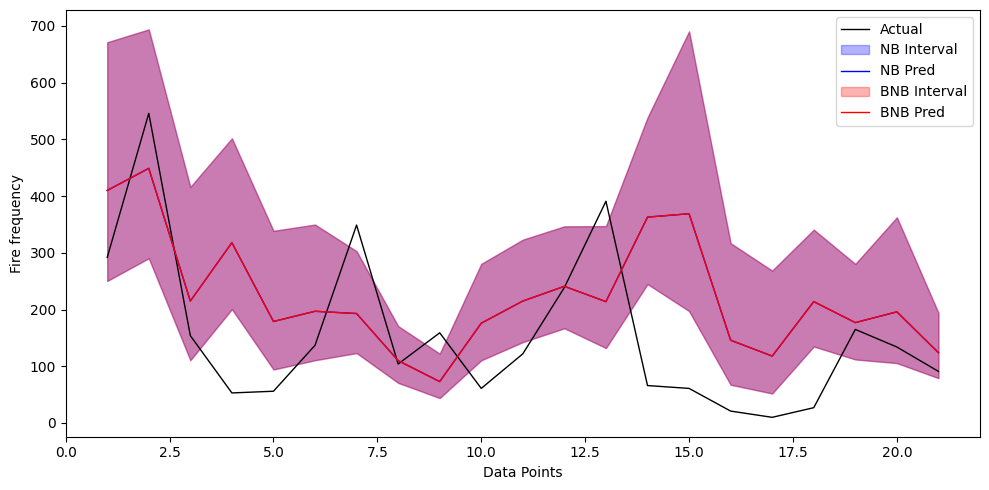

In [52]:
# R lines 512–530: ggplot ribbon + lines
plt.figure(figsize=(10,5))
plt.plot(df['x'], df['y'], color='black', linewidth=1, label='Actual')
plt.fill_between(df['x'], df['modelNB_lower'], df['modelNB_upper'],
                 alpha=0.3, color='blue', label='NB Interval')
plt.plot(df['x'], df['modelNB_pred'], color='blue', linewidth=1, label='NB Pred')
plt.fill_between(df['x'], df['modelBNB_lower'], df['modelBNB_upper'],
                 alpha=0.3, color='red', label='BNB Interval')
plt.plot(df['x'], df['modelBNB_pred'], color='red', linewidth=1, label='BNB Pred')
plt.xlabel('Data Points')
plt.ylabel('Fire frequency')
plt.legend()
plt.tight_layout()
plt.show()

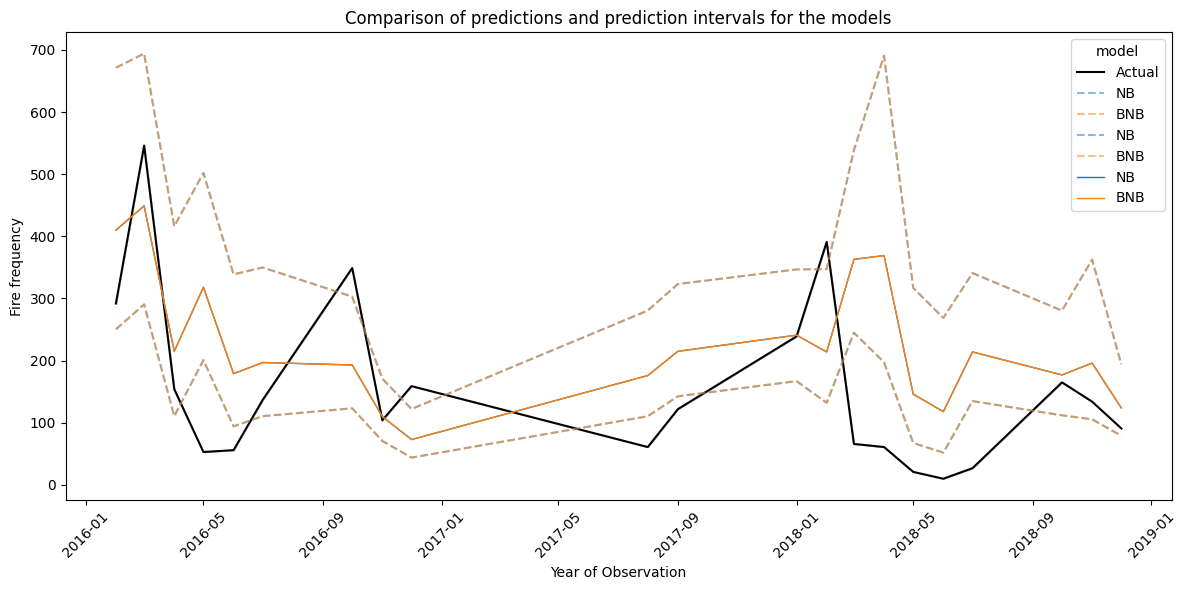

In [53]:
# R lines 532–540: combined time-series ribbon facet
# Use 'month_year' column (matches R code: pidata$month_year)
plt.figure(figsize=(12,6))
sns.lineplot(data=pidata, x='month_year', y='count', color='black', label='Actual')
sns.lineplot(data=pidata, x='month_year', y='lower', hue='model', linestyle='--', alpha=0.5)
sns.lineplot(data=pidata, x='month_year', y='upper', hue='model', linestyle='--', alpha=0.5)
sns.lineplot(data=pidata, x='month_year', y='pred', hue='model', linewidth=1)
plt.title('Comparison of predictions and prediction intervals for the models')
plt.xlabel('Year of Observation')
plt.ylabel('Fire frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

BNB corr: PearsonRResult(statistic=0.4248770746984401, pvalue=0.05486840984636015)
NB corr:  PearsonRResult(statistic=0.4248770746984401, pvalue=0.05486840984636015)


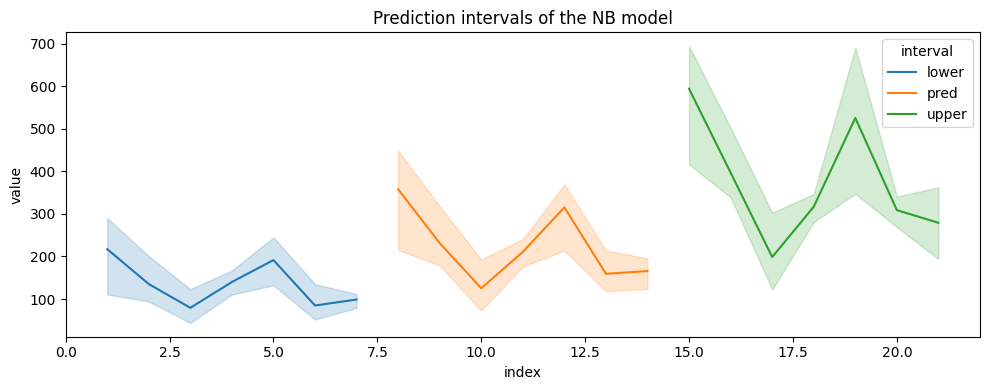

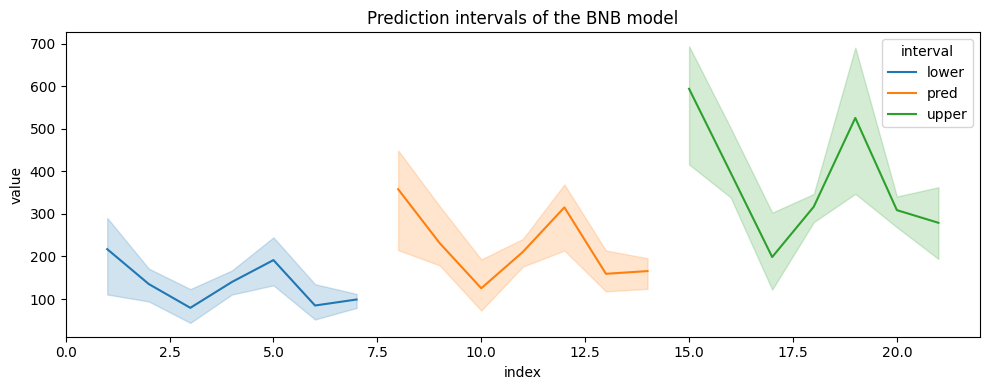

In [61]:
# R lines 542–548: cor.test
print("BNB corr:", stats.pearsonr(bnbdata['count'], bnbdata['pred']))
print("NB corr: ", stats.pearsonr(nbdata['count'], nbdata['pred']))

# R lines 550–578: pivot_longer & patchwork
# Fix: Use actual test set size and avoid column name conflict
test_set_size = len(nbdata)

# Create long format for NB data (rename actual count to avoid conflict)
nb_data_clean = nbdata.rename(columns={'count': 'actual'})
nb_long = nb_data_clean.melt(id_vars=['actual'], value_vars=['lower','pred','upper'],
                      var_name='interval', value_name='value').assign(
    index=lambda df: np.repeat(np.arange(1, test_set_size + 1), 3)
)
plt.figure(figsize=(10,4))
sns.lineplot(data=nb_long, x='index', y='value', hue='interval')
plt.title('Prediction intervals of the NB model')
plt.tight_layout()
plt.show()

# Create long format for BNB data 
bnb_data_clean = bnbdata.rename(columns={'count': 'actual'})
bnb_long = bnb_data_clean.melt(id_vars=['actual'], value_vars=['lower','pred','upper'],
                        var_name='interval', value_name='value').assign(
    index=lambda df: np.repeat(np.arange(1, test_set_size + 1), 3)
)
plt.figure(figsize=(10,4))
sns.lineplot(data=bnb_long, x='index', y='value', hue='interval')
plt.title('Prediction intervals of the BNB model')
plt.tight_layout()
plt.show()

In [62]:
# Debug: Check what columns nb_long and bnb_long actually have
print("nb_long columns:", nb_long.columns.tolist())
print("nb_long shape:", nb_long.shape)
print("nb_long head:")
print(nb_long.head())
print()
print("bnb_long columns:", bnb_long.columns.tolist()) 
print("bnb_long shape:", bnb_long.shape)
print("bnb_long head:")
print(bnb_long.head())


nb_long columns: ['actual', 'interval', 'value', 'index']
nb_long shape: (63, 4)
nb_long head:
   actual interval       value  index
0     292    lower  250.472604      1
1     546    lower  290.491292      1
2     154    lower  110.685256      1
3      53    lower  200.838311      2
4      56    lower   94.311292      2

bnb_long columns: ['actual', 'interval', 'value', 'index']
bnb_long shape: (63, 4)
bnb_long head:
   actual interval       value  index
0     292    lower  250.472604      1
1     546    lower  290.491292      1
2     154    lower  110.685256      1
3      53    lower  200.838311      2
4      56    lower   94.311292      2


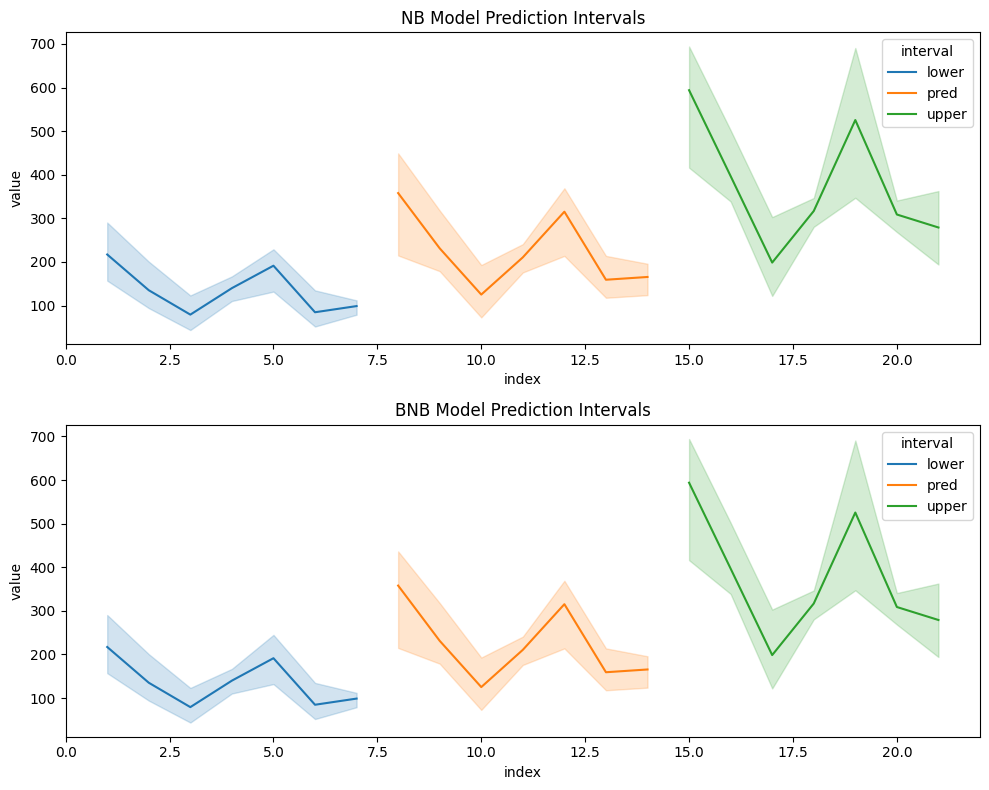

nb_long columns: ['actual', 'interval', 'value', 'index']
bnb_long columns: ['actual', 'interval', 'value', 'index']


In [63]:
# CORRECTED: To "stack" them (patchwork), use subplots:
# Fixed column name from 'count' to 'value' (from melt operation)
fig, axes = plt.subplots(2,1, figsize=(10,8))
sns.lineplot(data=nb_long, x='index', y='value', hue='interval', ax=axes[0]).set_title('NB Model Prediction Intervals')
sns.lineplot(data=bnb_long, x='index', y='value', hue='interval', ax=axes[1]).set_title('BNB Model Prediction Intervals')
plt.tight_layout()
plt.show()

# Also show the column names to verify
print("nb_long columns:", list(nb_long.columns))
print("bnb_long columns:", list(bnb_long.columns))
